# Semantic Segmentation

### GPU Configurations

In [1]:
import os                # Operating system-related functions (file, directory operations)
import sys               # Provides access to system-specific parameters and functions
import platform          # Provides functions and information about the operating system and hardware

import numpy as np       # NumPy library for numerical operations & array manipulation
import pickle            # for object serialization & deserialization
import random            # generates random numbers

import cv2               # computer vision & image processing
import tensorflow as tf  # deep learning framework
import keras             # training & evaluating deep learning models

from skimage.io import imread   # reading images
from skimage.io import imshow   # displaying images
from tqdm import tqdm           # creating progress bars in loops
from typing import List         # type hinting
from typing import Tuple         # type hinting
import matplotlib.pyplot as plt # creating plots & visualizations

In [2]:
# Check Operating System & Platform
print('Operating System:', platform.system(), platform.release())
print('Python Platform:', platform.platform())

# Check Python Environment & Version
print('Python Environment:', sys.executable)
print('Python Version:', sys.version)
print()

# Print library versions
print('NumPy Version:', np.__version__)
print('OpenCV Version:', cv2.__version__)
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print()

# Check if any GPU is available
print('GPU is Available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('Number of GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Operating System: Darwin 22.6.0
Python Platform: macOS-13.5.2-arm64-arm-64bit
Python Environment: /Users/xiongyun/miniconda3/envs/tensorflow/bin/python
Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]

NumPy Version: 1.24.3
OpenCV Version: 4.8.0
TensorFlow Version: 2.13.0
Keras Version: 2.13.1

GPU is Available: True
Number of GPUs Available: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit for the first GPU to 0.31
        gpu_memory_limit = 0.30
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(gpu_memory_limit * 1024))]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Memory limit must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-09-14 09:56:26.386085: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-09-14 09:56:26.386101: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-14 09:56:26.386107: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-14 09:56:26.386134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-14 09:56:26.386147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Pre-processing

1. Create Directories
2. Data Split
3. Image Tiling
5. Preview
6. Broadcast Images into Arrays

#### Access Directories

The directory containing the dataset used in this notebook is  **'../datasets/deepglobe/train'**. Create directories from the dataset's directory for the training, validation, and test data (if they do not exist). Additionally, create a directory to store pickled Numpy arrays for later usage.

In [4]:
# Current Working Directory
print(os.getcwd())

# Directories containing datasets
dataset_dir = '../datasets/deepglobe/train'
pickle_dir = os.path.join(dataset_dir, 'original_pickle')

/Users/xiongyun/Desktop/ESP4901/models


## Model Design

The model used in segmentation is based on the U-net model. The model uses the same activation, kernel initializer and padding for all convolutional layers as it is a simplified model. 

The model is optimized with the Adam Optimizer and loss is calculated based on Dice Loss.

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import IoU

# Build U-NET Model
def unet_model(IMG_WIDTH: int, IMG_HEIGHT: int, IMG_CHANNELS: int = 3,
               activation: str = 'relu', kernel_initializer: str = 'he_normal', padding: str = 'same') -> Model:
    
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting Path / (Higher-Level) Feature Learning
    c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(inputs)
    c1 = Dropout(0.1)(c1) # dropout=0.1
    c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
        
    c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c5)

        
    # Expanding Path / Restore Resolution
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding=padding)(c9)

    # final convolutional layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[IoU(num_classes=2, target_class_ids=[1])])
    return model

## Model Training

#### Load Data

In [6]:
# unpickle X_validation, y_validation

with open(os.path.join(pickle_dir, 'X_validation.pkl'), 'rb') as f:
    X_validation = pickle.load(f)

with open(os.path.join(pickle_dir, 'y_validation.pkl'), 'rb') as f:
    y_validation = pickle.load(f)

In [7]:
#%%script echo
# Error: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 
# to /job:localhost/replica:0/task:0/device:GPU:0
# in order to run _EagerConst: Dst tensor is not initialized
# prevent eager execution
tf.compat.v1.disable_eager_execution()

In [8]:
%%capture captured_output
training_unet_model = unet_model(256, 256)
training_unet_model.summary()

In [9]:
# Initialize empty lists to store data splits
X_train_splits = []
y_train_splits = []

# Load and concatenate data splits
for i in range(5):
    with open(os.path.join(pickle_dir, f'X_split_{i}.pkl'), 'rb') as f:
        X_train_split = pickle.load(f)
        X_train_splits.append(X_train_split)

    with open(os.path.join(pickle_dir, f'y_split_{i}.pkl'), 'rb') as f:
        y_train_split = pickle.load(f)
        y_train_splits.append(y_train_split)

# Concatenate the splits along the first axis (axis=0) to form the complete data
X_train = np.concatenate(X_train_splits, axis=0)
y_train = np.concatenate(y_train_splits, axis=0)

In [11]:
with open(os.path.join(pickle_dir, 'X_train_1.pkl'), 'wb') as f:
    pickle.dump(X_train, f)

with open(os.path.join(pickle_dir, 'y_train_1.pkl'), 'wb') as f:
    pickle.dump(y_train, f)

: 

In [10]:
X_train.shape

(39840, 256, 256, 3)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
#from tqdm.keras import TqdmCallback

checkpointer = ModelCheckpoint('unet_model_256.h5', verbose=1, save_best_only=True)

callbacks = [EarlyStopping(patience=3, monitor='val_loss'),
             TensorBoard(log_dir='logs_256_float16'), checkpointer],
             #TqdmCallback(verbose=2)]

training_unet_model.fit(X_train_split, y_train_split, 
                            validation_data=(X_validation, y_validation), 
                            epochs=10, batch_size=64, callbacks=callbacks)

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tqdm.keras import TqdmCallback

checkpointer = ModelCheckpoint('unet_model_256.h5', verbose=1, save_best_only=True)

callbacks = [EarlyStopping(patience=3, monitor='val_loss'),
             TensorBoard(log_dir='logs_256_float16'), checkpointer,
             TqdmCallback(verbose=2)]

# Training loop
for i in range(10):
    # Load training data
    with open(os.path.join(pickle_dir, f'X_split_{i}.pkl'), 'rb') as f:
        X_train_split = pickle.load(f)

    with open(os.path.join(pickle_dir, f'y_split_{i}.pkl'), 'rb') as f:
        y_train_split = pickle.load(f)
    
    # Train your model on the current split with the same validation data
    training_unet_model.fit(X_train_split, y_train_split, 
                            validation_data=(X_validation, y_validation), 
                            epochs=10, batch_size=2, callbacks=callbacks)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/996 [00:00<?, ?batch/s]

Epoch 1/10


2023-09-14 03:35:00.439848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 21/996 [..............................] - ETA: 37:40 - loss: 0.6887 - io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14GFamilyCommandBuffer: 0x4b14e1b10>
    label = <none> 
    device = <AGXG14GDevice: 0x1682d1600>
        name = Apple M2 
    commandQueue = <AGXG14GFamilyCommandQueue: 0x2958a3a00>
        label = <none> 
        device = <AGXG14GDevice: 0x1682d1600>
            name = Apple M2 
    retainedReferences = 1


996/996 [==============================] - ETA: 0s - loss: 0.5179 - io_u: 0.0000e+00

2023-09-14 04:18:42.386106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.38469, saving model to unet_model_256.h5
996/996 [==============================] - 5798s 6s/step - loss: 0.5179 - io_u: 0.0000e+00 - val_loss: 0.3847 - val_io_u: 0.0000e+00


/Users/xiongyun/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0.00/996 [00:00<?, ?batch/s]

Epoch 2/10
996/996 [==============================] - ETA: 0s - loss: 0.3151 - io_u: 0.0000e+00
Epoch 2: val_loss improved from 0.38469 to 0.25769, saving model to unet_model_256.h5
996/996 [==============================] - 5794s 6s/step - loss: 0.3151 - io_u: 0.0000e+00 - val_loss: 0.2577 - val_io_u: 0.0000e+00


  0%|          | 0.00/996 [00:00<?, ?batch/s]

Epoch 3/10
996/996 [==============================] - ETA: 0s - loss: 0.2316 - io_u: 0.0000e+00
Epoch 3: val_loss improved from 0.25769 to 0.20418, saving model to unet_model_256.h5
996/996 [==============================] - 5808s 6s/step - loss: 0.2316 - io_u: 0.0000e+00 - val_loss: 0.2042 - val_io_u: 0.0000e+00


  0%|          | 0.00/996 [00:00<?, ?batch/s]

Epoch 4/10
996/996 [==============================] - ETA: 0s - loss: 0.1968 - io_u: 0.0000e+00

KeyboardInterrupt: 

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

checkpointer = ModelCheckpoint('unet_model_256.h5', verbose=1, save_best_only=True)

callbacks = [EarlyStopping(patience=3, monitor='val_loss'),
             TensorBoard(log_dir='logs_256_float16'), checkpointer]

# Training loop
for i in range(10):
    # Load training data
    with open(os.path.join(pickle_dir, f'X_split_{i}.pkl'), 'rb') as f:
        X_train_split = pickle.load(f)

    with open(os.path.join(pickle_dir, f'y_split_{i}.pkl'), 'rb') as f:
        y_train_split = pickle.load(f)
    
    # Train your model on the current split with the same validation data
    training_unet_model.fit(X_train_split, y_train_split, 
                            validation_data=(X_validation, y_validation), 
                            epochs=10, batch_size=64, callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.2254 - io_u: 3.1282e-07 
Epoch 1: val_loss improved from inf to 0.15263, saving model to unet_model_256.h5
125/125 [==============================] - 2269s 18s/step - loss: 0.2254 - io_u: 3.1282e-07 - val_loss: 0.1526 - val_io_u: 0.0000e+00
Epoch 2/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  7/125 [>.............................] - ETA: 14:15 - loss: 0.1669 - io_u: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model


tf.compat.v1.disable_eager_execution()

model_name = 'unet_model_256'

# Load Saved U-Net Model
loaded_model = load_model(f'{model_name}.h5')

# Load test data
with open(os.path.join(pickle_dir, 'X_test.pkl'), 'rb') as f:
    X_test = pickle.load(f)

with open(os.path.join(pickle_dir, 'y_test.pkl'), 'rb') as f:
    y_test = pickle.load(f)

# Evaluate on test data
test_loss = loaded_model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')

In [13]:
!tensorboard --logdir=logs/ --host localhost --port 8088

TensorBoard 2.13.0 at http://localhost:8088/ (Press CTRL+C to quit)
^C


## Model Evaluation

In [3]:
from keras.models import load_model
from matplotlib import pyplot as plt

with open(os.path.join(pickle_dir, 'X_validation.pkl'), 'rb') as f:
    X_validation = pickle.load(f)

with open(os.path.join(pickle_dir, 'y_validation.pkl'), 'rb') as f:
    y_validation = pickle.load(f)

with open(os.path.join(pickle_dir, 'X_test.pkl'), 'rb') as f:
    X_test = pickle.load(f)

with open(os.path.join(pickle_dir, 'y_test.pkl'), 'rb') as f:
    y_test = pickle.load(f)

#### Load Model

In [4]:
def calculate_iou(pred: np.ndarray, mask: np.ndarray, threshold: float = 0.5) -> float:
    '''
    Calculate Intersection over Union (IoU) for binary masks.

    Args:
        pred (np.ndarray): Predicted mask.
        mask (np.ndarray): Ground truth mask.
        threshold (float, optional): Binarization threshold. Default is 0.5.

    Returns:
        iou (float): IoU score.
    '''
    pred_bin = (pred > threshold)
    intersection = np.logical_and(mask, pred_bin)
    union = np.logical_or(mask, pred_bin)
    iou = np.sum(intersection) / np.sum(union)
    return iou


def find_best_threshold_for_iou(pred: np.ndarray, mask: np.ndarray) -> Tuple[float, float]:
    '''
    Find the best threshold that maximizes the Intersection over Union (IoU) score.

    Args:
        pred (np.ndarray): Predicted binary mask with shape (H, W, 1).
        mask (np.ndarray): Ground truth binary mask with shape (H, W, 1).

    Returns:
        best_threshold, best_iou (Tuple[float, float]): The best threshold value.
    '''
    best_threshold = 1.0
    best_iou = 0.0

    # Iterate over different threshold values
    for threshold in np.arange(1.0, 0.0, -0.01):
        iou = calculate_iou(pred, mask, threshold)
        if iou > best_iou:
            best_iou = iou
            best_threshold = threshold

    return best_threshold, best_iou

1/1 [==============================] - 0s 23ms/step


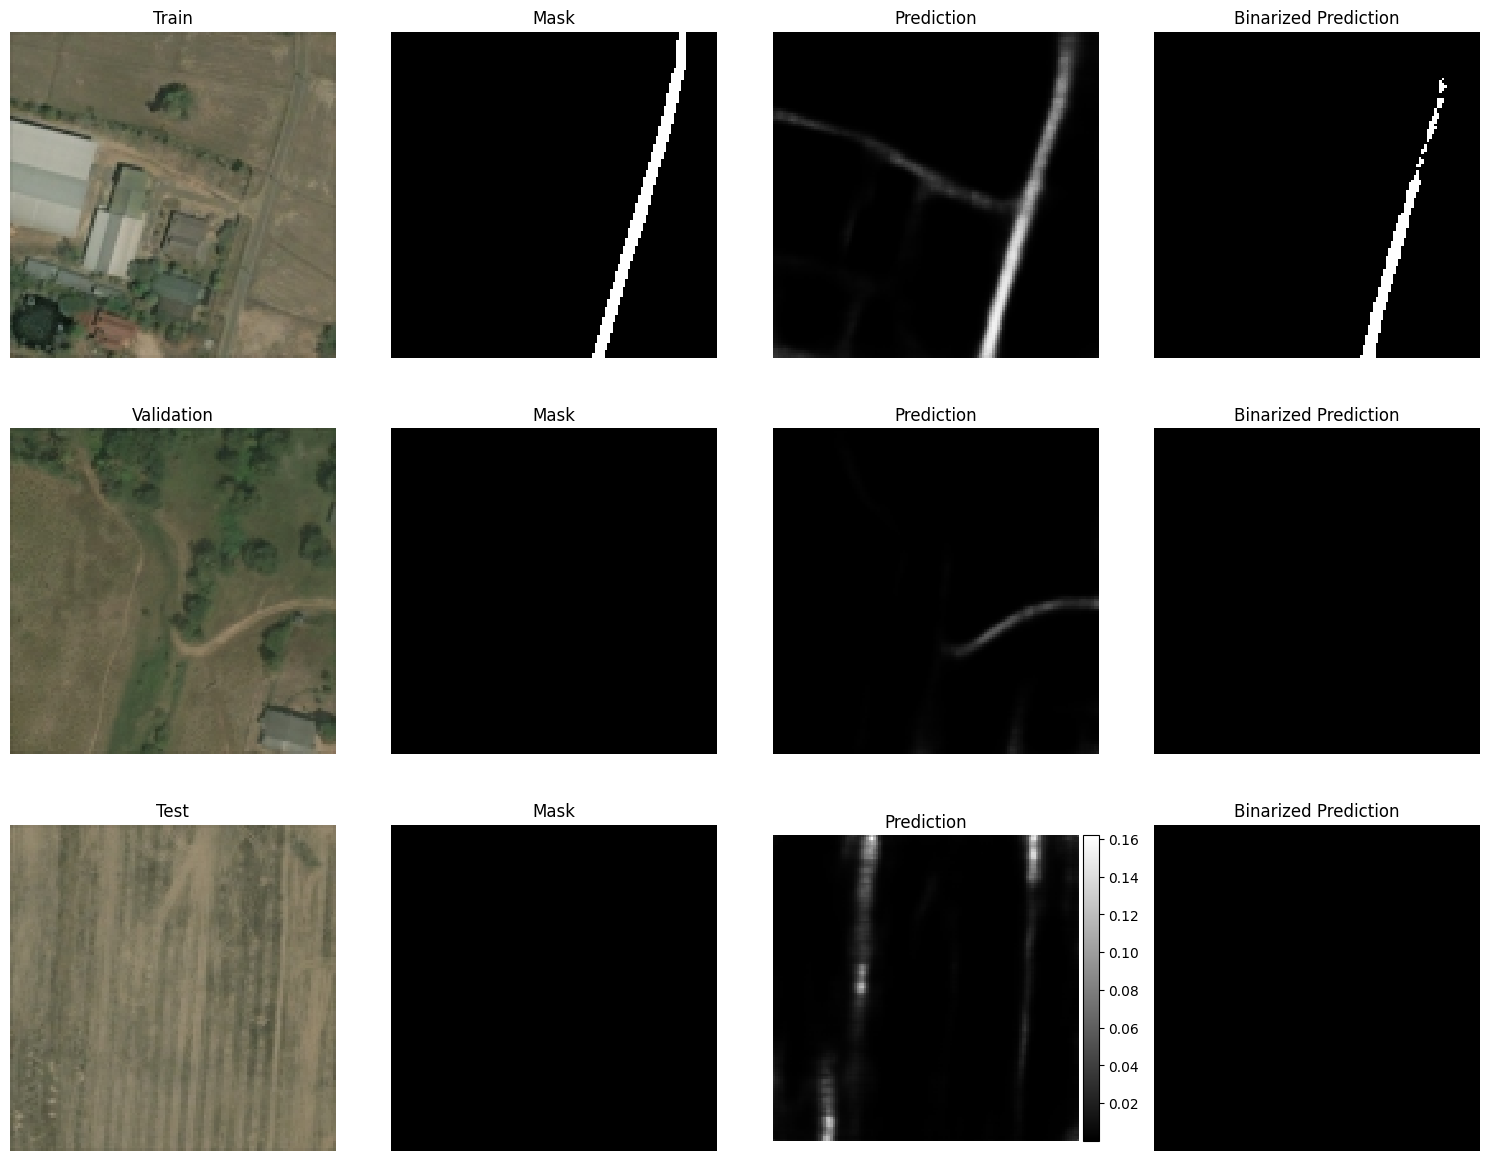

In [12]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Set seed=?
#random.seed(1)

datasets = [('Train', X_train, y_train), ('Validation', X_validation, y_validation), ('Test', X_test, y_test)]

# Create Figure
rows = len(datasets)
columns = 4
fig = plt.figure(figsize=(15, 15))

for i, (name, images, masks) in enumerate(datasets):
    idx = random.randint(0, len(images))
    
    # Reshaping Image, change data type to float16 -> float32
    pred_image = images[idx].astype(np.float32)
    pred_image = pred_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
    # Reshaping Mask
    mask_image = masks[idx]
    mask_image = mask_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

    # Predict Road Segmentation
    pred = loaded_model.predict(pred_image, verbose=1)

    # Find Best Threshold
    # best_threshold, best_iou = find_best_threshold_for_iou(pred, mask_image)

    # Binarise Prediction Mask
    pred_bin = (pred > 0.5)

    # Loop through subplot titles and their indices
    for j, subplot_title in enumerate([name, 'Mask', 'Prediction', 'Binarized Prediction']):
        subplot_idx = j + 1 + i * columns
        subplot = fig.add_subplot(rows, columns, subplot_idx)

        if subplot_title == 'Mask':
            image = mask_image[0]
        elif subplot_title == 'Prediction':
            image = pred
        elif subplot_title == 'Binarized Prediction':
            image = pred_bin
        else:
            image = pred_image[0]
        
        imshow(np.squeeze(image), cmap='gray', ax=subplot)
        subplot.axis('off')
        subplot.set_title(subplot_title)

plt.tight_layout()
plt.show()